# Reconfiguring a workflow for hybrid compute environments
One of the great things about cloud is the ability to construct hybrid GPU-CPU environments for efficient processing. This, however can bring challenges around design and configuration of bulk processing flows.

Ideally our signal processing experts and data scientists can design a workflow with a limited, but representative, subset of the data. They can do this work locally on laptop or desktop. When we have a signal processing flow in place, we want to transfer this to the most efficient bulk processing scheme on the available hardware.

Although there is a useful [comparison table between numpy and cupy](https://docs-cupy.chainer.org/en/stable/reference/comparison.html) it is cumbersome to continually be cross-referencing that against the [distpy Command Reference](https://github.com/Schlumberger/distpy/wiki/Command-Dictionary). We want the processing experts to concentrate on developing workflows, and the cloud experts to concentrate on deployment. We also want a common view for discussion at daily stand-ups.

In this tutorial we will show how a complex **distpy** signal processing chain can be reconfigured to a hybrid GPU-CPU environment.

At the end of this tutorial you will know how to:
1. Autodocument a flow and how to customize self-documented flows
2. Create the developer view for analysing an existing flow
3. How to reconfigure flows for GPU-CPU



## Preliminaries
This flow requires **distpy** version 1.23.0 or higher. The cell below will show which version you are using, you can update via 
`pip install --upgrade distpy`

In [1]:
import distpy
print(distpy.__version__)

1.23.0


## A more complicated flow

If you have already worked through the [seismic quicklook plots](https://github.com/Schlumberger/distpy/wiki/User-Tutorial-:-distpy-on-linux), 
[noise log](https://github.com/Schlumberger/distpy/wiki/User-Tutorial-:--distpy-on-cloud), and [event detection](https://github.com/Schlumberger/distpy/wiki/User-Tutorial-:-dispty-on-windows)
tutorials, the following workflow is the amalgamation of all 3 and provides an indication of the type of bulk processing flows associated with 
Distributed Acoustic Sensing (DAS) and the rich array of results that can be created.



In [2]:
myFlow = {
"document" : 0,
"description" : "A more complex example of a DAS processing flow",
"command_list" :
[
 { "name" : "butter",         "uid" :  1, "in_uid" : 0, "type" : "lowpass", "freq" : 200 },
 { "name" : "butter",         "uid" :  2, "in_uid" : 1, "type" : "highpass", "freq" : 5 },
 { "name" : "thumbnail",      "uid" :  3, "in_uid" : 2, "directory_out" : "png" },
 { "name" : "fft",            "uid" :  4, "in_uid" :  0, "axis" : 1 },
 { "name" : "rms_from_fft",   "uid" :  5, "in_uid" :  4, "low_freq" : 0, "high_freq" : -1 },
 { "name" : "multiple_calcs", "uid" :  6, "in_uid" :  4,   "func" : "te_from_fft",     "low_freq" : [200,600,1000], "high_freq" : [-1,-1,-1] },
 { "name" : "write_witsml",   "uid" :  7, "in_uid" :  6, "directory_out" : "NoiseLog", "low_freq" : [200,600,1000], "high_freq" : [-1,-1,-1],  "gather_uids" : [5], "data_style" : "NoiseLog" },
 { "name" : "fft",            "uid" : 8, "in_uid" :  4, "axis" : 0},
 { "name" : "velocity_map",   "uid" : 9, "in_uid" :  8},
 { "name" : "velocity_mask",  "uid" : 10, "in_uid" :  9, "min_velocity" : 15000, "max_velocity" : 20000, "smooth" : 1.02 },
 { "name" : "multiply",       "uid" : 11, "in_uid" :  8, "gather_uids" : [10] },
 { "name" : "ifft",           "uid" : 12, "in_uid" : 11, "axis" : 0},
 { "name" : "ifft",           "uid" : 13, "in_uid" : 12, "axis" : 1},
 { "name" : "real",           "uid" : 14, "in_uid" : 13},
 { "name" : "butter",         "uid" : 15, "in_uid" : 14, "freq" : 600, "order" : 5, "type" : "highpass"},
 { "name" : "thumbnail",      "uid" : 16, "in_uid" : 15, "directory_out" : "filtered_png", "format" : "png" },
 { "name" : "multiply",       "uid" : 17, "in_uid" : 15, "gather_uids" : [15] },
 { "name" : "sta_lta",        "uid" : 18, "in_uid" : 17, "sta" : 50, "lta" : 200},
 { "name" : "thumbnail",      "uid" : 19, "in_uid" : 18, "directory_out" : "events_png", "format" : "png" },
 { "name" : "peak_to_peak",   "uid" : 20, "in_uid" : 18, "window_length" : 200},
 { "name" : "write_witsml",   "uid" : 21, "in_uid" : 20, "directory_out" : "p2p", "low_freq" : [0], "high_freq" : [1],  "gather_uids" : [5], "data_style" : "p2p" }
]
}

## Documenting flows for end-users
Within **distpy** we make use of [GraphViz](https://graphviz.gitlab.io/_pages/pdf/dotguide.pdf) to rapidly picture the 
directed-graph structure of workflows.



Using TensorFlow backend.


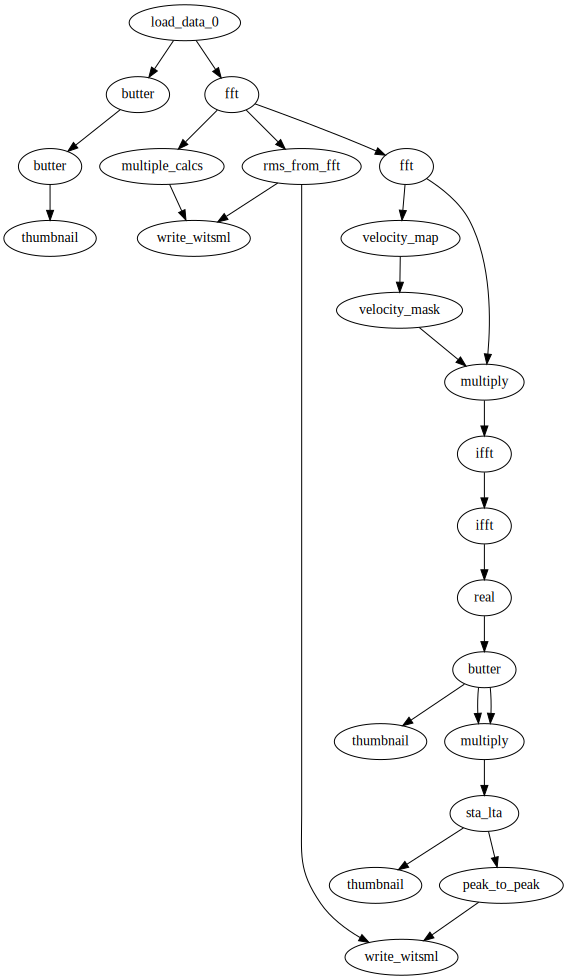

In [3]:
from IPython.display import SVG, Latex, Markdown
from graphviz import Source
from ipywidgets import interactive
from IPython.display import display
import copy

import distpy.io_help.io_helpers as io_helpers
import distpy.workers.strainrate2summary

# Feed the command list into the dot_graph function
dotgraph = io_helpers.dot_graph(myFlow['command_list'])

# display the results as a Scalable Vector Graphic
graph = Source(' '.join(dotgraph))
display(SVG(graph.pipe(format='svg')))

To enhance the presentation for the end-user, we use the optional `comment` and `formatting` fields on the commands. 
For example to highlight the noise logging path we could use the following code.

## Highlighting the Noise Logging path

We highlight the noise logging path by setting the comment and formatting fields in the noise logging commands.

The section of interest is highlighted in green and yellow.

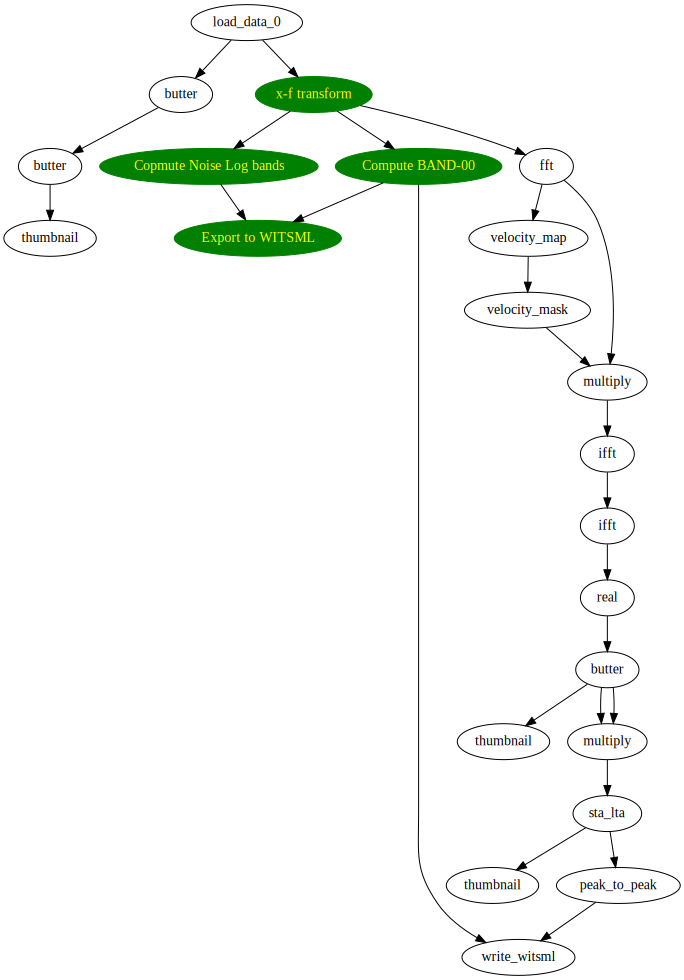

In [4]:
from IPython.display import SVG, Latex, Markdown
from graphviz import Source
from ipywidgets import interactive
from IPython.display import display
import copy

import distpy.io_help.io_helpers as io_helpers
import distpy.workers.strainrate2summary


lines=[]
lines.append('## Highlighting the Noise Logging path')
lines.append('We highlight the noise logging path by setting the comment and formatting fields in the noise logging commands.')
lines.append('The section of interest is highlighted in green and yellow.')

formatting = "color=green,style=filled,fontcolor=yellow"
myFlow['command_list'][3]['comment']='x-f transform'
myFlow['command_list'][4]['comment']='Compute BAND-00'
myFlow['command_list'][5]['comment']='Copmute Noise Log bands'
myFlow['command_list'][6]['comment']='Export to WITSML'
for a in range(3,7):
    myFlow['command_list'][a]['formatting'] = formatting


# Feed the command list into the dot_graph function
dotgraph = io_helpers.dot_graph(myFlow['command_list'])


# Display the text
for line in lines:
    display(Markdown(line))

# display the results as a Scalable Vector Graphic
graph = Source(' '.join(dotgraph))
display(SVG(graph.pipe(format='svg')))

## Documenting flows for the deployment team
Whilst it is very useful to freely comment and colour workflows for end-users, the deployment team are usually more interested
in details - what functions are used and which are GPU-compatible.

**distpy** allows the generation of a null command structure, which mimics the objects created at run-time. Feeding this into the `dot_graph`
function returns a view of the flow with the key details.

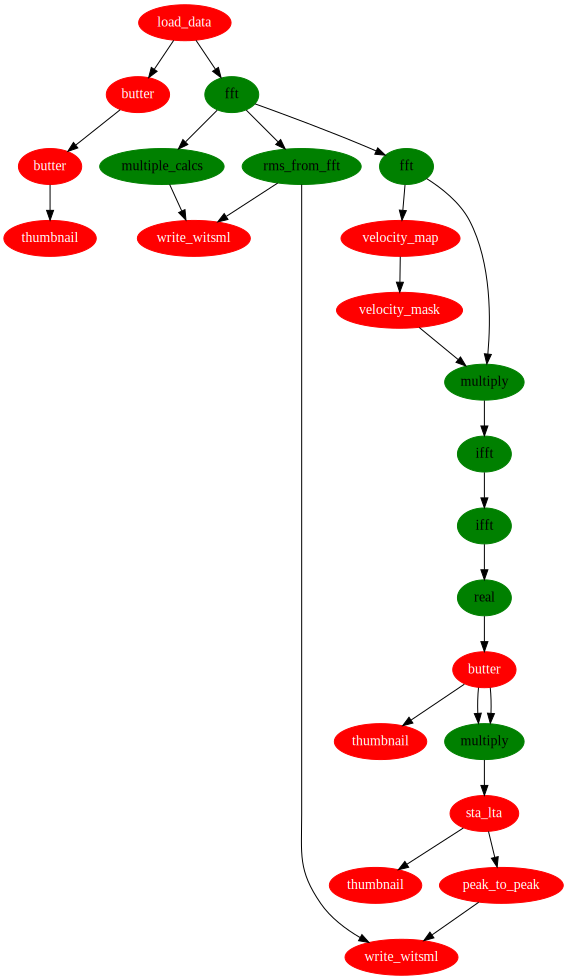

## All the commands used in this workflow and their default settings

## load_data

This command cannot be used with GPU.

## butter

Setup a Butterworth filter using scipy.signal.butter() and apply it using scipy.signal.filtfilt()

`order` : The order for a filter calculation such as the Butterworth filter

default : 5

`type` : The type of a filter which can be lowpass, highpass, bandpass, or bandstop

default : lowpass

`padtype` : The type of end-effect control on a filter, see scipy.signal.filtfilt

default : even

`prf` : The pulse repetition frequency in Hz (one over the time sample rate)

default : 10000

`freq` : A frequency in Hz or a wavenumber in 1/m

default : 200.0

`axis` : The axis to apply an operation to, typically in distpy axis=0 for depth and axis=1 for time

default : -1

This command cannot be used with GPU.

## butter

Setup a Butterworth filter using scipy.signal.butter() and apply it using scipy.signal.filtfilt()

`order` : The order for a filter calculation such as the Butterworth filter

default : 5

`type` : The type of a filter which can be lowpass, highpass, bandpass, or bandstop

default : lowpass

`padtype` : The type of end-effect control on a filter, see scipy.signal.filtfilt

default : even

`prf` : The pulse repetition frequency in Hz (one over the time sample rate)

default : 10000

`freq` : A frequency in Hz or a wavenumber in 1/m

default : 200.0

`axis` : The axis to apply an operation to, typically in distpy axis=0 for depth and axis=1 for time

default : -1

This command cannot be used with GPU.

## thumbnail

Create a thumbnail image of the current 2D processed data in the specified format.

`directory_out` : The subdirectory where results will be written

default : NONE

`format` : The format of the picture output

default : png

`clip_level` : The number of standard devaitions about the mean for plotting thumbnails

default : 1.0

This command cannot be used with GPU.

## fft

Compute the Fast Fourier Transform (FFT) of the data along the requested axis.

`axis` : The axis to apply an operation to, typically in distpy axis=0 for depth and axis=1 for time

default : -1

This command can be used with GPU.

## rms_from_fft

Calculate the RMS energy between two frequencies.

`low_freq` : A list of low frequency values for band-pass windows in Hz

default : None

`high_freq` : A list of high frequency values for band-pass windows in Hz

default : None

This command can be used with GPU.

## multiple_calcs

Perform multiple calculations using the extra_numpy.reduced_mem() system.

`low_freq` : A list of low frequency values for band-pass windows in Hz

default : None

`high_freq` : A list of high frequency values for band-pass windows in Hz

default : None

`func` : Either rms_from_fft or te_from_fft

This command can be used with GPU.

## write_witsml

Write out to the WITSML/FBE format, suitable for loading into viewers such as Techlog or Petrel.

`directory_out` : The subdirectory where results will be written

default : NONE

`xaxis` : A numpy vector of distances along the fibre

default : None

`data_style` : A string identifier for the data inside the WITSML file

default : NONE

`low_freq` : A list of low frequency values for band-pass windows in Hz

default : None

`high_freq` : A list of high frequency values for band-pass windows in Hz

default : None

`labels` : A list of column headers

This command cannot be used with GPU.

## fft

Compute the Fast Fourier Transform (FFT) of the data along the requested axis.

`axis` : The axis to apply an operation to, typically in distpy axis=0 for depth and axis=1 for time

default : -1

This command can be used with GPU.

## velocity_map

Calculate the phase velocity at each pixel in a 2D FFT space.

This command cannot be used with GPU.

## velocity_mask

Construct a phase-velocity filter in 2D space. The input should be from the velocity_map command.

`min_velocity` : The minimum phase velocity

default : 1400

`max_velocity` : The maximum phase velocity

default : 1600

This command cannot be used with GPU.

## multiply

Elementwise multiply, the output data-type will be the same as that of the data entering in the in_uid. This data is multiplied by data provided in the gather_uids

This command can be used with GPU.

## ifft

Compute the Inverse Fast Fourier Transform (IFFT) of the data along the requested axis.

`axis` : The axis to apply an operation to, typically in distpy axis=0 for depth and axis=1 for time

default : -1

This command can be used with GPU.

## ifft

Compute the Inverse Fast Fourier Transform (IFFT) of the data along the requested axis.

`axis` : The axis to apply an operation to, typically in distpy axis=0 for depth and axis=1 for time

default : -1

This command can be used with GPU.

## real

Take the real value of the input

This command can be used with GPU.

## butter

Setup a Butterworth filter using scipy.signal.butter() and apply it using scipy.signal.filtfilt()

`order` : The order for a filter calculation such as the Butterworth filter

default : 5

`type` : The type of a filter which can be lowpass, highpass, bandpass, or bandstop

default : lowpass

`padtype` : The type of end-effect control on a filter, see scipy.signal.filtfilt

default : even

`prf` : The pulse repetition frequency in Hz (one over the time sample rate)

default : 10000

`freq` : A frequency in Hz or a wavenumber in 1/m

default : 200.0

`axis` : The axis to apply an operation to, typically in distpy axis=0 for depth and axis=1 for time

default : -1

This command cannot be used with GPU.

## thumbnail

Create a thumbnail image of the current 2D processed data in the specified format.

`directory_out` : The subdirectory where results will be written

default : NONE

`format` : The format of the picture output

default : png

`clip_level` : The number of standard devaitions about the mean for plotting thumbnails

default : 1.0

This command cannot be used with GPU.

## multiply

Elementwise multiply, the output data-type will be the same as that of the data entering in the in_uid. This data is multiplied by data provided in the gather_uids

This command can be used with GPU.

## sta_lta

Short-term average (STA) divided by long-term average (LTA). This transform highlights onset and so often forms part of an automated pick or edge-detection.

`sta` : The short-term average window-length in samples

default : 50

`lta` : The long-term average window-length in samples

default : 200

This command cannot be used with GPU.

## thumbnail

Create a thumbnail image of the current 2D processed data in the specified format.

`directory_out` : The subdirectory where results will be written

default : NONE

`format` : The format of the picture output

default : png

`clip_level` : The number of standard devaitions about the mean for plotting thumbnails

default : 1.0

This command cannot be used with GPU.

## peak_to_peak

The maximum peak-to-peak difference with the maximum and minimum separated by less than the defined window_length. This reduces the data from 2D (x,t) to a trace (x).

`window_length` : The length of a filter window in samples

default : 5

This command cannot be used with GPU.

## write_witsml

Write out to the WITSML/FBE format, suitable for loading into viewers such as Techlog or Petrel.

`directory_out` : The subdirectory where results will be written

default : NONE

`xaxis` : A numpy vector of distances along the fibre

default : None

`data_style` : A string identifier for the data inside the WITSML file

default : NONE

`low_freq` : A list of low frequency values for band-pass windows in Hz

default : None

`high_freq` : A list of high frequency values for band-pass windows in Hz

default : None

`labels` : A list of column headers

This command cannot be used with GPU.

In [5]:
from IPython.display import SVG, Latex, Markdown
from graphviz import Source
from ipywidgets import interactive
from IPython.display import display

import distpy.io_help.io_helpers as io_helpers
import distpy.workers.strainrate2summary

# build the null command set
command_list = distpy.workers.strainrate2summary.build_command_list(myFlow)
# pass this, together with the command list, to the graph to get the default Developer View
dotgraph = io_helpers.dot_graph(myFlow['command_list'],command_list)


graph = Source(' '.join(dotgraph))
display(SVG(graph.pipe(format='svg')))

# Build the command reference for this workflow
lines=[]
lines.append('## All the commands used in this workflow and their default settings')
for command in command_list:
    lines = io_helpers.command2md(command,lines)

for line in lines:
    display(Markdown(line))

## Reconfiguring a flow for GPU-CPU

With the diagram above we can see the processes that are GPU-enabled (green) and those which are not (red). A naive approach, which turns out to be useful in a lot of cases, is to break the workflow at each red process and replace that break-in-the-chain with a `write_npy`. This allows you to pick up the chain on a separately configured CPU node and take it from there.

Alternatively you could insert a `to_gpu` and `from_gpu` at the top and bottom of each green section, if you are working with GPU-CPU hybrid nodes for your compute.

Since the velocity filter is identical for every data chunk, we can avoid needless calculation, and streamline the processing for GPU, by pre-computing that filter once and storing it. The two steps used to generate the filter are then repaced by the GPU-friendly `load_data` node. This does, however introduce a read-from-disk, which is slow for GPU. As always, benchmarking is important for efficient bulk processing chains.

A particular point for discussion in this workflow, is the Butterworth filter applied late in the event detection part, we can see a chain of green broken by that step. This is because [`scipy.signal.butter` is not available in cupy](https://docs-cupy.chainer.org/en/stable/reference/comparison.html). However, it is possible to define a Fourier domain filter to replace this, which could be applied between the two `ifft` commands. This is can be more efficient than transferring `from_gpu` and back `to_gpu`, although again benchmarking is the key.


A deployment configuration for a GPU-CPU hybrid node, with that butterworth filter replaced by loading and applying a stored Fourier domain filter, is given below.

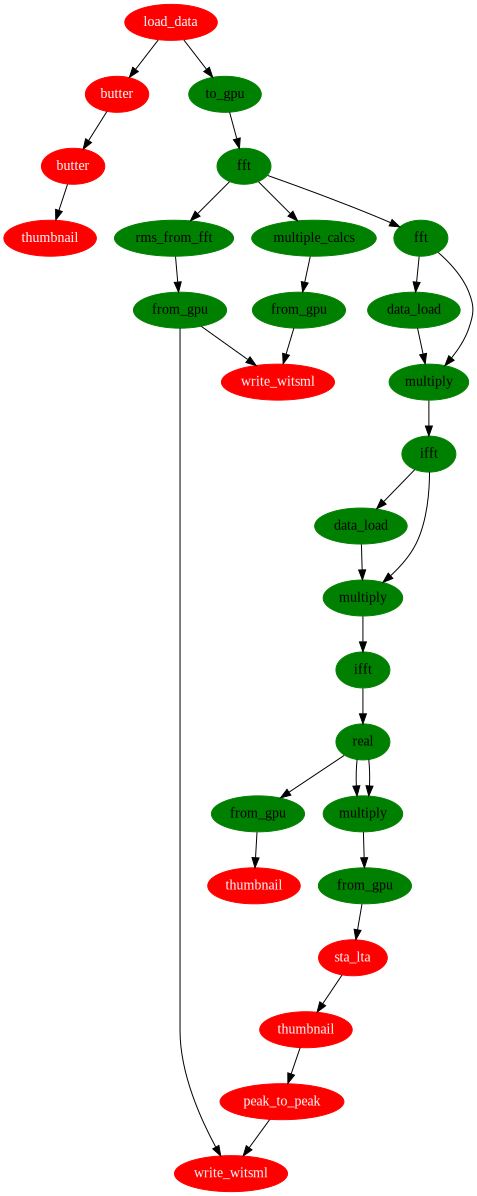

In [6]:
myFlowGPU = {
"document" : 0,
"description" : "A more complex example of a DAS processing flow",
"command_list" :
[
 { "name" : "butter",         "uid" :  1, "in_uid" : 0, "type" : "lowpass", "freq" : 200 },
 { "name" : "butter",         "uid" :  2, "in_uid" : 1, "type" : "highpass", "freq" : 5 },
 { "name" : "thumbnail",      "uid" :  3, "in_uid" : 2, "directory_out" : "png" },
 { "name" : "to_gpu",         "uid" :  4, "in_uid" : 0 },    
 { "name" : "fft",            "uid" :  5, "in_uid" :  4, "axis" : 1 },
 { "name" : "rms_from_fft",   "uid" :  6, "in_uid" :  5, "low_freq" : 0, "high_freq" : -1 },
 { "name" : "multiple_calcs", "uid" :  7, "in_uid" :  5,   "func" : "te_from_fft",     "low_freq" : [200,600,1000], "high_freq" : [-1,-1,-1] }, 
 { "name" : "from_gpu",       "uid" :  8, "in_uid" :  6 },
 { "name" : "from_gpu",       "uid" :  9, "in_uid" :  7 },
 { "name" : "write_witsml",   "uid" : 10, "in_uid" :  9, "directory_out" : "NoiseLog", "low_freq" : [200,600,1000], "high_freq" : [-1,-1,-1],  "gather_uids" : [8], "data_style" : "NoiseLog" },
 { "name" : "fft",            "uid" : 11, "in_uid" :  5, "axis" : 0},
 { "name" : "data_load",      "uid" : 12, "in_uid" : 11, "filename" : "filters/velocity.npy"},
 { "name" : "multiply",       "uid" : 13, "in_uid" : 11, "gather_uids" : [12] },
 { "name" : "ifft",           "uid" : 14, "in_uid" : 13, "axis" : 0},
 { "name" : "data_load",      "uid" : 15, "in_uid" : 14, "filename" : "filters/butter.npy"},
 { "name" : "multiply",       "uid" : 16, "in_uid" : 14, "gather_uids" : [15] },
 { "name" : "ifft",           "uid" : 17, "in_uid" : 16, "axis" : 1},
 { "name" : "real",           "uid" : 18, "in_uid" : 17},
 { "name" : "from_gpu",       "uid" : 19, "in_uid" : 18 },
 { "name" : "thumbnail",      "uid" : 20, "in_uid" : 19, "directory_out" : "filtered_png", "format" : "png" },
 { "name" : "multiply",       "uid" : 21, "in_uid" : 18, "gather_uids" : [18] },
 { "name" : "from_gpu",       "uid" : 22, "in_uid" : 21 },
 { "name" : "sta_lta",        "uid" : 23, "in_uid" : 22, "sta" : 50, "lta" : 200},
 { "name" : "thumbnail",      "uid" : 24, "in_uid" : 23, "directory_out" : "events_png", "format" : "png" },
 { "name" : "peak_to_peak",   "uid" : 25, "in_uid" : 24, "window_length" : 200},
 { "name" : "write_witsml",   "uid" : 26, "in_uid" : 25, "directory_out" : "p2p", "low_freq" : [0], "high_freq" : [1],  "gather_uids" : [8], "data_style" : "p2p" }
]
}

# build the null command set
command_list = distpy.workers.strainrate2summary.build_command_list(myFlowGPU)
# pass this, together with the command list, to the graph to get the default Developer View
dotgraph = io_helpers.dot_graph(myFlowGPU['command_list'],command_list)


graph = Source(' '.join(dotgraph))
display(SVG(graph.pipe(format='svg')))


## Summary

In this tutorial we learned how to:
1. Autodocument a flow and how to customize self-documented flows
2. Create the developer view for analysing an existing flow
3. How to reconfigure flows for GPU-CPU

Once you have the configuration, deployment can be delivered via the [Docker container](https://github.com/Schlumberger/distpy/wiki/User-Tutorial-:-Docker-and-Kubernetes), but there are plenty of other alternatives. Of course, testing and benchmarking are important, GPU enabled workflows can be fast provided the additional I/O doesn't outweigh the performance gains.